<a href="https://colab.research.google.com/github/sanaamouzahir/NonLinearModelling/blob/main/MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math as m
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving inferencedata.mat to inferencedata.mat
Saving ktrue.mat to ktrue.mat


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving covariance_matrix.mat to covariance_matrix.mat


In [ ]:
import scipy.io

# Load MATLAB data file
inference_data= scipy.io.loadmat('inferencedata.mat')
ktrue=scipy.io.loadmat('ktrue.mat')
xobserved=inference_data['xobserved']
Uobserved=inference_data['Uobserved'].reshape(10)
k_true=ktrue['ktrue']
xgrid=ktrue['xgrid']
cov=scipy.io.loadmat('covariance_matrix.mat')
cov=cov['Cov matrix:']

In [ ]:
# Copyright 2023 Daniel Sharp
# Permission is hereby granted, free of charge, to any person
# obtaining a copy of this software and associated documentation
# files (the “Software”), to deal in the Software without
# restriction, including without limitation the rights to use,
# copy, modify, merge, publish, distribute, sublicense, and/or
# sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following
# conditions:
# The above copyright notice and this permission notice shall be
# included in all copies or substantial portions of the Software.
# THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND,
# EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
# OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
# HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
# WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
# OTHER DEALINGS IN THE SOFTWARE.

import numpy as np

def covfun(x1, x2, L=0.3, var_y=0.3):
    return var_y*np.exp(-np.abs(x1-x2)/L)

def form_KL_uniform(covfun, lo, hi, num_quad):
    pts, wts = np.polynomial.legendre.leggauss(num_quad)
    pts = (pts * (hi-lo)/2) + (hi + lo)/2
    wts *= (hi-lo)/2
    mesh1, mesh2 = np.meshgrid(pts, pts)
    C_mat = covfun(mesh1, mesh2)
    W_half = np.diag(np.sqrt(wts))
    A = W_half @ C_mat @ W_half
    lam, phi = np.linalg.eigh(A)
    psi = np.diag(1 / np.sqrt(wts)) @ phi
    lam = lam[::-1]
    psi = psi[:,::-1]
    psi = psi * (2*(psi[0,:] > 0) - 1)
    return lam, psi, pts, wts

class KLE:
    def __init__(self, lam, psi, pts, wts, covfun):
        self.lam = lam
        self.psi = psi
        self.pts = pts
        self.wts = wts
        self.covfun = covfun

def default_KLE(N_trunc, num_quad = 100):
    lam, psi, pts, wts = form_KL_uniform(covfun, 0., 1., num_quad)
    return KLE(lam[:N_trunc], psi[:,:N_trunc], pts, wts, covfun)

def eval_KLE(kl, xgrid, z = None):
    if z is None:
        rng = np.random.default_rng()
        z = rng.standard_normal(len(kl.lam))
    X,Y = np.meshgrid(kl.pts, xgrid)
    covmat = kl.covfun(X,Y) @ np.diag(kl.wts)
    psi_evals = covmat @ kl.psi @ np.diag(1/np.sqrt(kl.lam))
    return psi_evals,kl.lam

def ExampleKLE():
    # Load data
    data = scipy.io.loadmat('inferencedata.mat')
    x_observed = data['xobserved'].flatten()
    U_observed = data['Uobserved'].flatten()
    xgrid = x_observed
    n_trunc = 100
    kl = default_KLE(n_trunc, max(100, round(1.5*n_trunc)))
    rng = np.random.default_rng()
    z = rng.standard_normal(n_trunc)
    kl_eval = eval_KLE(kl, xgrid, z)
    return xgrid, kl_eval, z



In [ ]:

def diffusioneqn(xgrid, F, k, source, rightbc):
    N = len(xgrid)
    h = xgrid[N-1] - xgrid[N-2]

    A = np.zeros((N-1, N-1))
    b = np.zeros(N-1)

    if isinstance(source, (int, float)):
        f = -source * np.ones(N-1)
    else:
        f = -source[:N-1]

    A -= np.diag(2*k[:-1] + k[1:] + np.insert(k[:-2],0,k[0]))
    A += np.diag(  k[:-2] + k[1:-1], 1)
    A += np.diag(  k[:-2] + k[1:-1],-1)
    A /= 2 * h**2


    A[0, 1] += k[0] / h**2
    b[0] = 2 * F / h

    b[N-2] = rightbc * (k[N-1] + k[N-2]) / (2 * h**2)

    uinternal = np.linalg.solve(A, f - b)
    usolution = np.append(uinternal, rightbc)

    usolution=np.array([usolution[0],usolution[10],usolution[20],usolution[30],usolution[40],usolution[50],usolution[60],usolution[70],usolution[80],usolution[90]])

    return usolution

In [ ]:
import numpy as np

from scipy.stats import multivariate_normal



def calc_Gauss_mv(x, mean, cov):
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    exponent_term = -0.5 * np.dot((x - mean).T, np.dot(inv_cov, (x - mean)))
    output_val = exponent_term
    return output_val



import numpy as np

def mvnrnd(mu, sigma):
    R = np.linalg.cholesky(sigma)
    sample = mu + np.dot(R, np.random.randn(len(mu)))
    return sample



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

x =np.arange(0, 1.01, 0.01)

# Get truncated KL modes
mu_y = 1
KL_trunc_order = 10


KL=default_KLE(KL_trunc_order, num_quad = 100)

psi, lambda_ = eval_KLE(KL,x, z = None)


# Create mean and covariance matrices for prior and likelihood
sigma_e_2 = 1e-4
cov_data_obs = np.diag(sigma_e_2 * np.ones(10)) # Given in the project, variance of the noise
cov_Z_prior = np.diag(np.ones(KL_trunc_order)) # Identity matrix is the prior since prior we work with the asusmption that the Zs are iid standard normal
mean_Z_prior = np.zeros(KL_trunc_order)

# Parameters for the PDE solver
u_r = 1
F = -1
m_wall = np.array([0.2, 0.4, 0.6, 0.8])
s_width = 0.05
s_strength = 0.8

s = np.zeros_like(x) # How the source term was defined
for i in range(len(x)):
    s[i] = (s_strength / (np.sqrt(2 * np.pi) * s_width)) * np.sum(
        np.exp(-0.5 * ((x[i] - m_wall) ** 2) / s_width ** 2)
    )

N=200000

# MCMC Random walk parameter try for one parameter
np.random.seed(5)
cov_MCMC = cov


MC_x = np.zeros((KL_trunc_order, N))

Y_1 = mu_y + (MC_x[:, 0]).dot(psi.T) # Gaussian prior

k_1 = np.exp(Y_1)

obs_mean_1 = diffusioneqn(x, F, k_1,s,u_r)
obs_mean_prev=obs_mean_1

# Start MCMC chains
accept=0
for chain_time in range(1, N):  # Start from 1 since chain_time - 1 is used

    # Adaptive MC
    sd = 2.4 ** 2 / KL_trunc_order
    adaptive_eps = 0.001

    if chain_time > 2000: # Covariance matrix of the random coefficients
        cov_MCMC = (
            sd * np.cov(MC_x[:, chain_time-1].T)
            + sd * adaptive_eps * np.eye(KL_trunc_order)
        )


    # Proposal (y/x_n)
    #Mc_x: vector mean of joint distribution of Zis
    # covMCMC: Covariance of Zis
    # calc_gauss: returns multivariatenormalpdf

    proposal = mvnrnd(MC_x[:, chain_time - 1], cov_MCMC)
    Y_proposal = mu_y + ( proposal).dot(psi.T)
    k_proposal = np.exp(Y_proposal)

    obs_mean_proposal = diffusioneqn(x, F, k_proposal, s, u_r)

    # Evaluate all PDFs for alpha term
    pi_y =calc_Gauss_mv(Uobserved, obs_mean_proposal, cov_data_obs)+calc_Gauss_mv(proposal, mean_Z_prior, cov_Z_prior)


    pi_xn = calc_Gauss_mv(Uobserved, obs_mean_prev, cov_data_obs)+calc_Gauss_mv(MC_x[:, chain_time - 1], mean_Z_prior, cov_Z_prior)


    q_xn_y = calc_Gauss_mv(MC_x[:, chain_time - 1], proposal, cov_MCMC)
    q_y_xn = calc_Gauss_mv(proposal, MC_x[:, chain_time - 1], cov_MCMC)


    alpha =min(1,np.exp(pi_y + q_xn_y - pi_xn- q_y_xn))

    # Update next sample
    if np.random.rand() < alpha:
        MC_x[:, chain_time] = proposal
        Y_prev = Y_proposal
        obs_mean_prev = obs_mean_proposal
        accept+=1
    else:
        MC_x[:, chain_time] = MC_x[:, chain_time - 1]


# WE look for 10000 to see if the varuance is too big --->0.01*cov_Z_prior ONLY leads to good results
#





In [ ]:
print('Accepance rate ratio',accept/N)

Accepance rate ratio 0.105275


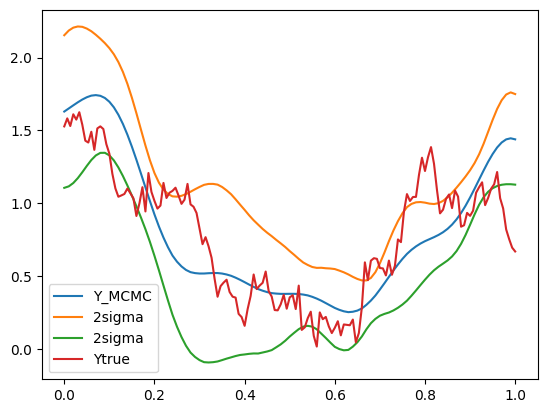

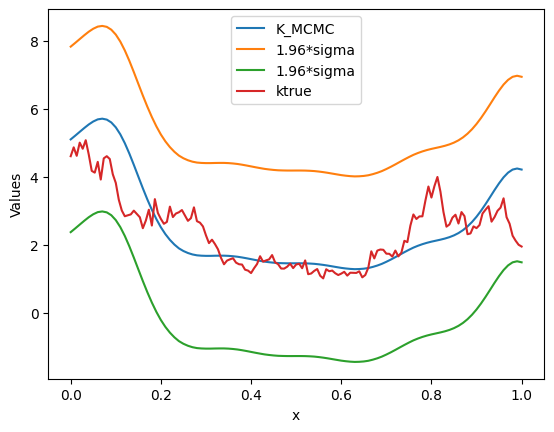

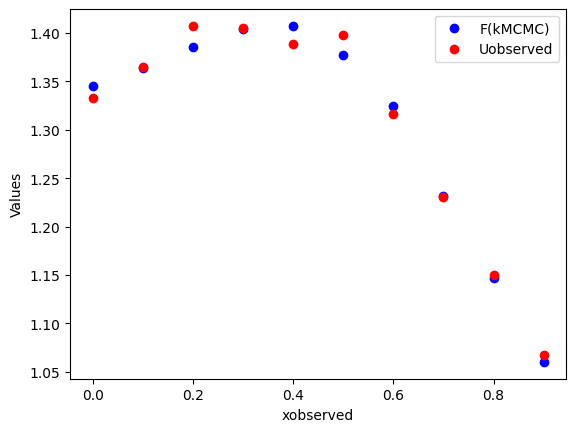

In [ ]:

t_burn_in = 50000
Y_MCMC = np.zeros((len(x), N-t_burn_in))
k_MCMC = np.zeros((len(x), N-t_burn_in))
u_MCMC=np.zeros(N-t_burn_in)
for j in range(t_burn_in , N):
  i = j - t_burn_in
  Y_MCMC[:, i ] = mu_y + (MC_x[:, j ]).dot(psi.T)
  k_MCMC[:, i ] = np.exp(Y_MCMC[:, i ])
  u_MCMC[i]=diffusioneqn(x, F, k_MCMC[:, i ], s, u_r)[0]
import numpy as np
import matplotlib.pyplot as plt

# Assuming x, Y_MCMC, ktrue, xgrid, xobserved, u_r, F, s, mean, std, u_values, and Uobserved are defined

# Plotting the first set of curves
plt.figure()
plt.plot(x, Y_MCMC[:,len(Y_MCMC)-1], label='Y_MCMC')
plt.plot(x, Y_MCMC[:,len(Y_MCMC)-1] + 2*np.std(Y_MCMC, axis=1), label='2sigma')
plt.plot(x, Y_MCMC[:,len(Y_MCMC)-1] - 2*np.std(Y_MCMC, axis=1), label='2sigma')
plt.plot(xgrid, np.log(k_true), label='Ytrue')
plt.legend()

# Plotting the first set of curves
plt.figure()
plt.plot(x, np.exp(Y_MCMC[:,len(Y_MCMC)-1]),label='K_MCMC')
plt.plot(x, np.exp(Y_MCMC[:,len(Y_MCMC)-1]) + 1.96*np.std(np.exp(Y_MCMC[:,len(Y_MCMC)])), label='1.96*sigma')
plt.plot(x, np.exp(Y_MCMC[:,len(Y_MCMC)-1]) - 1.96*np.std(np.exp(Y_MCMC[:,len(Y_MCMC)])), label='1.96*sigma')
# Plotting ktrue
plt.plot(xgrid, k_true, label='ktrue')

# Adding labels and legend
plt.xlabel('x')
plt.ylabel('Values')
plt.legend()
plt.show()

# Plotting the second set of curves
plt.figure()
plt.plot(xobserved, diffusioneqn(x,F,k_MCMC[:,len(k_MCMC)],s,u_r),'bo', label='F(kMCMC)')
plt.plot(xobserved, Uobserved, 'ro', label='Uobserved')

# Adding labels and legend
plt.xlabel('xobserved')
plt.ylabel('Values')
plt.legend()
plt.show()


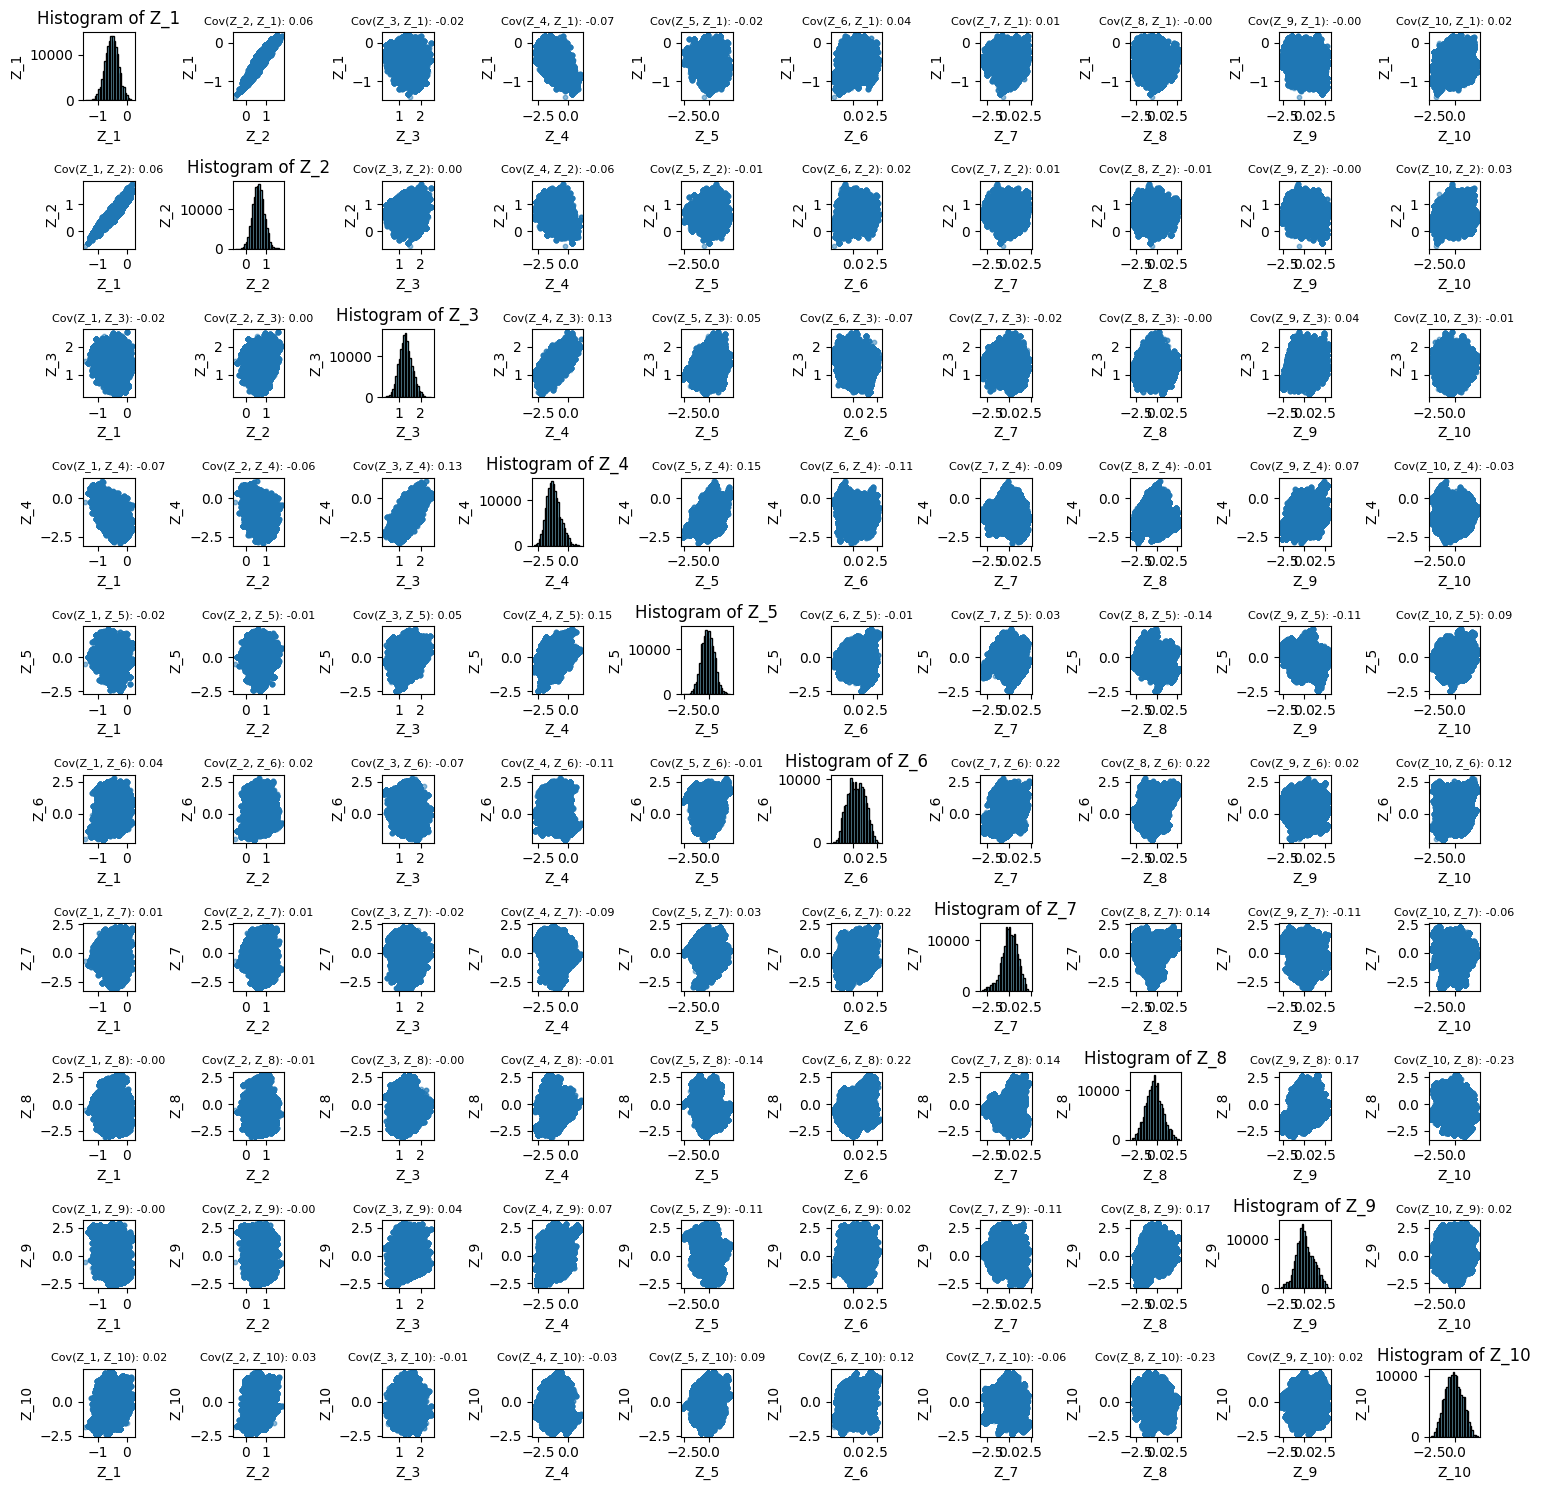

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have MC_x defined with shape (KL_trunc_order, num_iterations)
# Adjust these values accordingly based on your actual data

KL_trunc_order = 10  # Adjust based on your data
num_iterations = N  # Adjust based on your data
t_burn_in = 50000  # Adjust based on your data

# Calculate covariance matrix for MC_x
covariance_matrix = np.cov(MC_x[:, t_burn_in:])

# Create a scatter matrix with histograms
fig, axs = plt.subplots(KL_trunc_order, KL_trunc_order, figsize=(15, 15))
scatter_matrix = axs
for i in range(KL_trunc_order):
    for j in range(KL_trunc_order):
        if i == j:
            # Plot histogram on the diagonal
            axs[i, j].hist(MC_x[i, t_burn_in:], bins=30, color='skyblue', edgecolor='black')
            axs[i, j].set_title(f'Histogram of Z_{i+1}')
        else:
            # Plot scatter plot for off-diagonal elements
            axs[i, j].scatter(MC_x[j, t_burn_in:], MC_x[i, t_burn_in:], alpha=0.5, s=10)
            axs[i, j].set_title(f'Cov(Z_{j+1}, Z_{i+1}): {covariance_matrix[i, j]:.2f}', fontsize=8)

        axs[i, j].set_xlabel(f'Z_{j+1}')
        axs[i, j].set_ylabel(f'Z_{i+1}')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


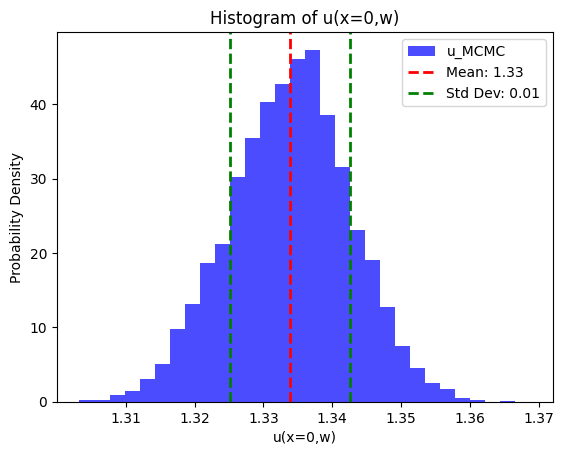

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# Plotting the histogram
plt.hist(u_MCMC, bins=30, density=True, alpha=0.7, color='blue', label='u_MCMC')

# Calculate mean and variance
mean_value = np.mean(u_MCMC)
variance_value = np.var(u_MCMC)

# Plotting mean and variance lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(mean_value + np.sqrt(variance_value), color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {np.sqrt(variance_value):.2f}')
plt.axvline(mean_value - np.sqrt(variance_value), color='green', linestyle='dashed', linewidth=2)

# Adding labels and title
plt.xlabel('u(x=0,w)')
plt.ylabel('Probability Density')
plt.title('Histogram of u(x=0,w)')
plt.legend()

plt.show()


In [ ]:
cov1 = np.cov(Y_MCMC)  # No truncation, no expansion
def covariance(X1,X2):
    Abs = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            Abs[i,j] = np.abs(X1[i]-X2[j])
    return 0.3*np.exp(-(Abs/0.3)**1/1)
cov2=covariance(x,x)





In [ ]:
cov=np.cov(MC_x[:, t_burn_in:])
from scipy.io import savemat

from google.colab import drive
drive.mount('/content/drive')
save_path='/content/drive/My Drive/covariance_matrix.mat'

savemat(save_path,{'Cov matrix:':cov})
import os
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


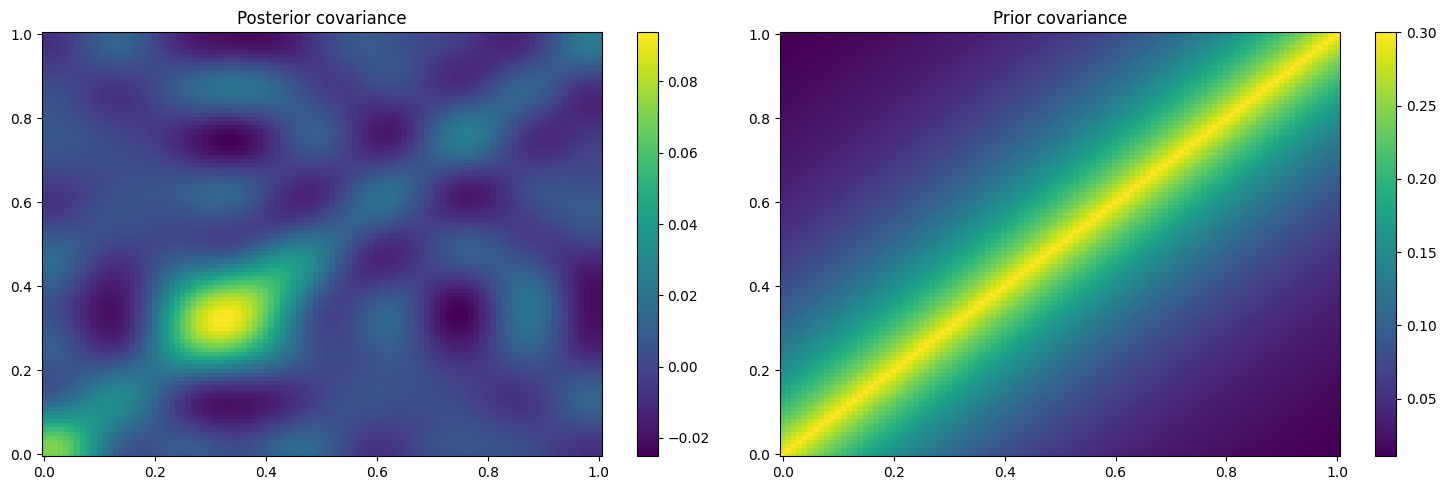

In [ ]:


# Create subplots for the three plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first covariance matrix
cax1 = axes[0].pcolor(x, x, cov1)
axes[0].set_title('Posterior covariance')
fig.colorbar(cax1, ax=axes[0])

# Plot the second covariance matrix
cax2 = axes[1].pcolor(x, x, cov2)
axes[1].set_title('Prior covariance')
fig.colorbar(cax2, ax=axes[1])

plt.tight_layout()
plt.show()


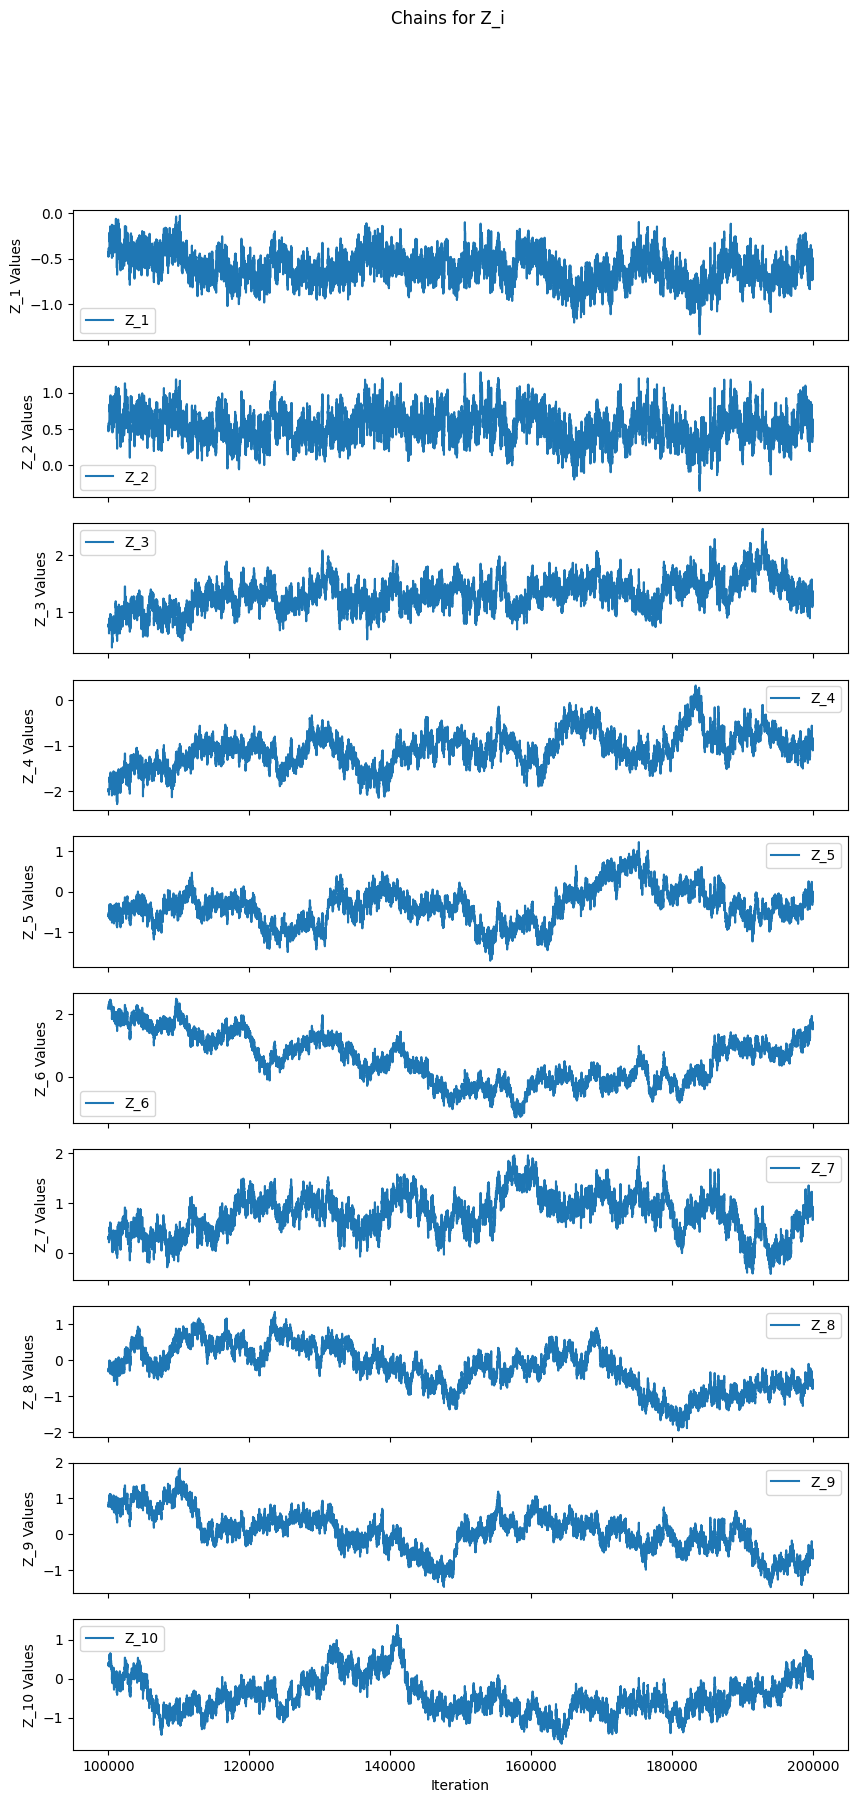

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have MC_x defined with shape (KL_trunc_order, num_iterations)
# Adjust these values accordingly based on your actual data

KL_trunc_order = 10  # Adjust based on your data
num_iterations = N  # Adjust based on your data

# Plotting all Zi in a single plot with subplots
fig, axs = plt.subplots(KL_trunc_order, 1, figsize=(10, 2 * KL_trunc_order), sharex=True)

for i in range(KL_trunc_order):
    axs[i].plot(range(100000,num_iterations), MC_x[i, 100000:], label=f'Z_{i+1}')
    axs[i].set_ylabel(f'Z_{i+1} Values')
    axs[i].legend()

# Adding labels and title
axs[-1].set_xlabel('Iteration')
fig.suptitle('Chains for Z_i')
plt.show()


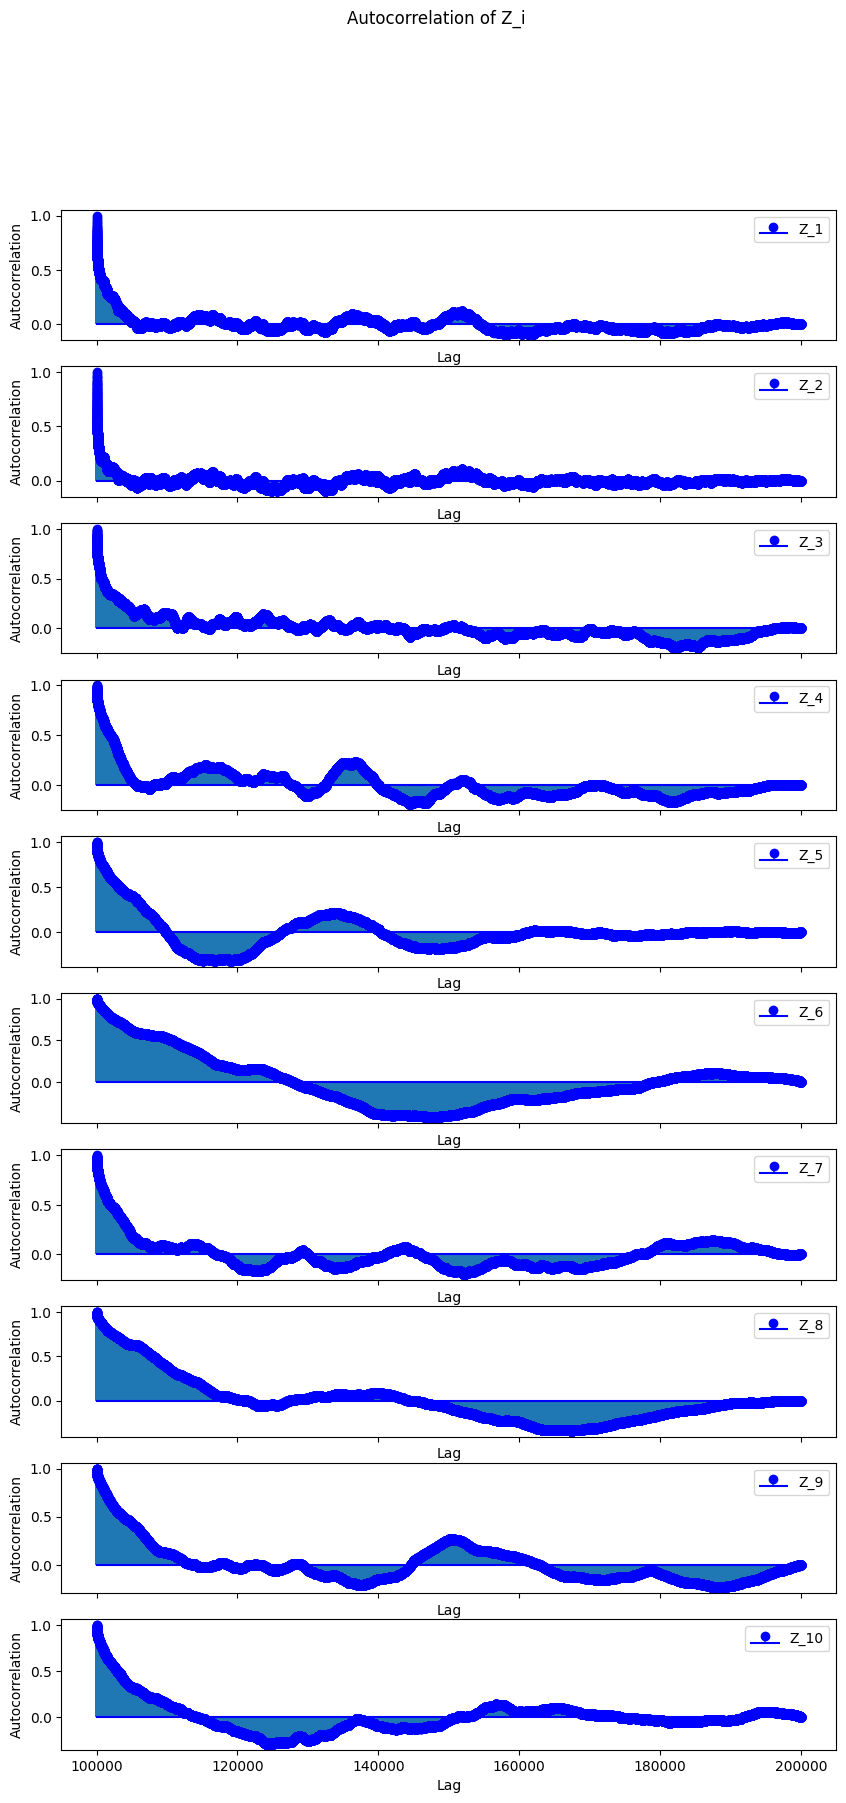

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


KL_trunc_order = 10  # Adjust based on your data
num_iterations = N# Adjust based on your data

# Calculate autocorrelation for each Z
autocorrelations = []

for i in range(KL_trunc_order):
    autocorr = np.correlate(MC_x[i, 100000:] - np.mean(MC_x[i, 100000:]), MC_x[i, 100000:] - np.mean(MC_x[i, 100000:]), mode='full')
    autocorr = autocorr / np.max(autocorr)  # Normalize to have values between -1 and 1
    autocorrelations.append(autocorr[num_iterations - 100000-1:])

# Plot autocorrelation for each Z
fig, axs = plt.subplots(KL_trunc_order, 1, figsize=(10, 2 * KL_trunc_order), sharex=True)

for i in range(KL_trunc_order):
    axs[i].stem(range(100000,num_iterations), autocorrelations[i], basefmt='b-', markerfmt='bo', label=f'Z_{i+1}')
    axs[i].set_xlabel('Lag')
    axs[i].set_ylabel('Autocorrelation')
    axs[i].legend()

# Adding title
fig.suptitle('Autocorrelation of Z_i')
plt.show()

# The posterior of the high Zs havign different values of the variance on the diagonal

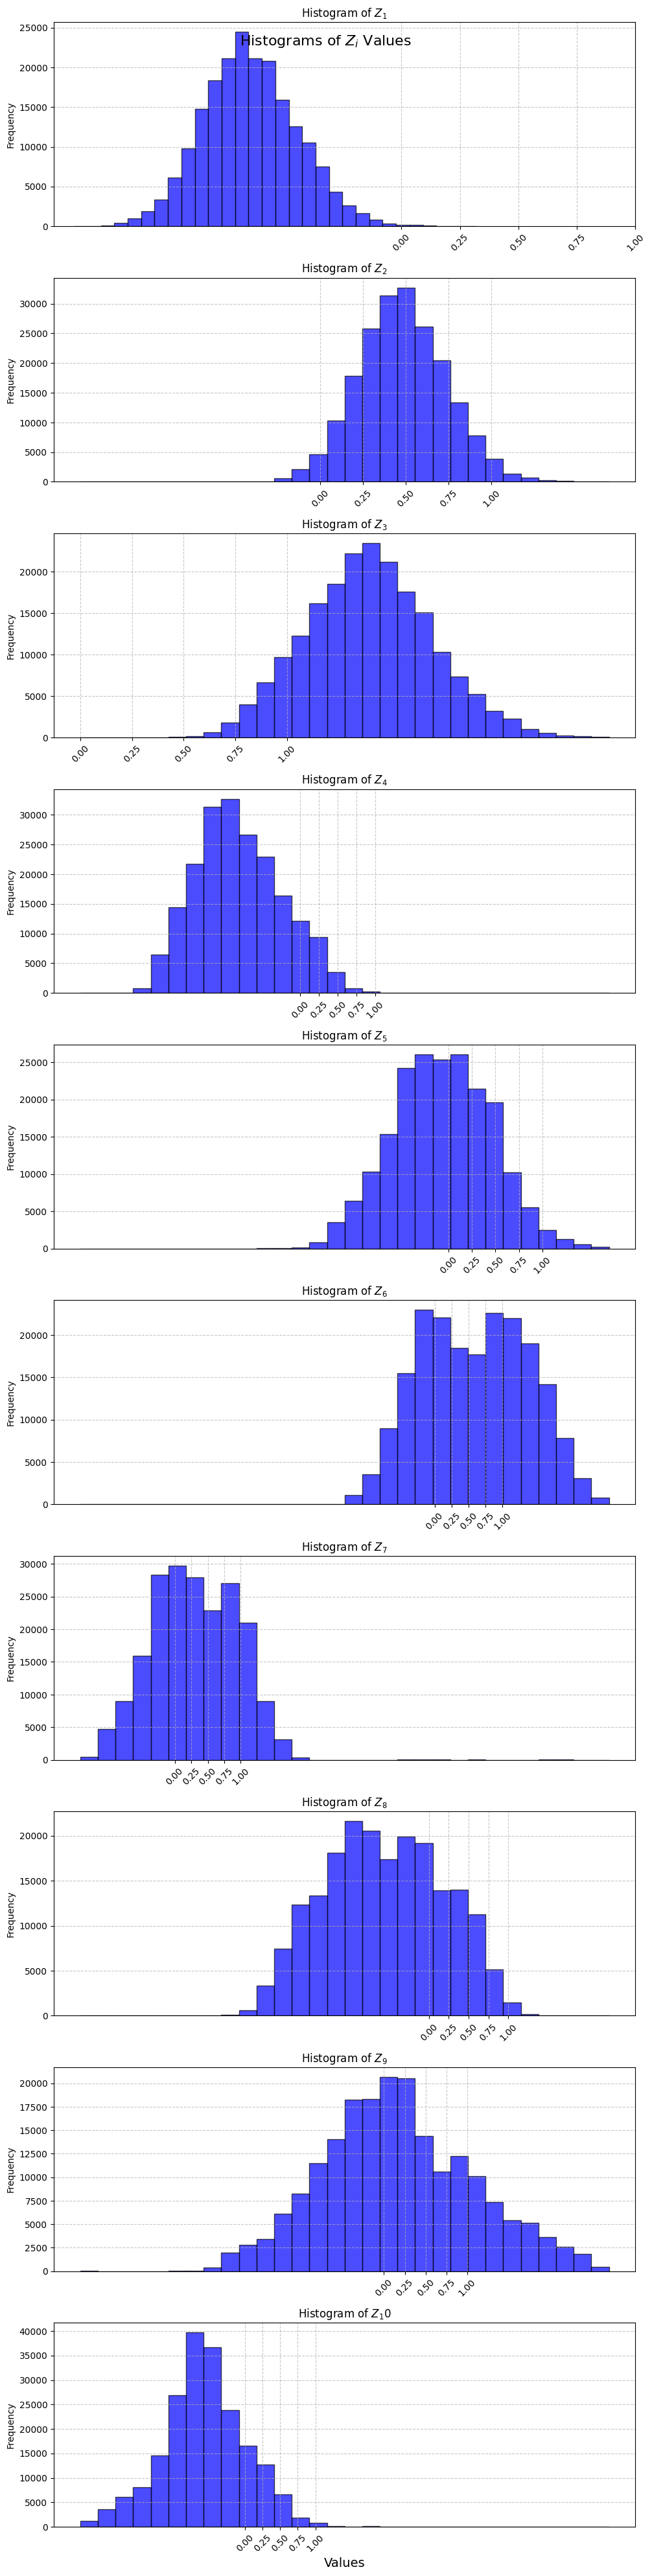

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have MC_x defined with shape (KL_trunc_order, num_iterations)
# Assuming x_values is the corresponding array of x-axis values
# Adjust these values accordingly based on your actual data

KL_trunc_order = 10  # Adjust based on your data
num_iterations = N # Adjust based on your data

# Assuming x_values is the corresponding array of x-axis values
x_values = np.linspace(0, 1, num_iterations)  # Adjust based on your data

# Plot histograms for each MC_x[i, :]
fig, axs = plt.subplots(KL_trunc_order, 1, figsize=(10, 4 * KL_trunc_order))

for i in range(KL_trunc_order):
    axs[i].hist(MC_x[i, :], bins=30, color='blue', alpha=0.7, edgecolor='black')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Histogram of $Z_{i+1}$')
    axs[i].grid(True, linestyle='--', alpha=0.7)
    axs[i].tick_params(axis='both', labelsize=10)
    axs[i].set_xticks(np.linspace(min(x_values), max(x_values), 5))
    axs[i].set_xticklabels([f'{value:.2f}' for value in np.linspace(min(x_values), max(x_values), 5)])
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better visibility

# Adding labels and title
fig.suptitle('Histograms of $Z_i$ Values', fontsize=16)
axs[-1].set_xlabel('Values', fontsize=14)

plt.tight_layout(pad=0.5, h_pad=1.0, w_pad=0.5)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import invgamma

x =np.arange(0, 1.01, 0.01)

# Get truncated KL modes
mu_y = 1
KL_trunc_order = 10


KL=default_KLE(KL_trunc_order, num_quad = 100)

psi, lambda_ = eval_KLE(KL,x, z = None)


# Create mean and covariance matrices for prior and likelihood
alpha_prior = 2.0
beta_prior= 1e-4
sigma_e_2_prior = invgamma.rvs(a=alpha_prior, scale=beta_prior)
cov_data_obs = np.diag(sigma_e_2_prior * np.ones(10)) # Given in the project, variance of the noise
cov_Z_prior = np.diag(np.ones(KL_trunc_order)) # Identity matrix is the prior since prior we work with the asusmption that the Zs are iid standard normal
mean_Z_prior = np.zeros(KL_trunc_order)

# Parameters for the PDE solver
u_r = 1
F = -1
m_wall = np.array([0.2, 0.4, 0.6, 0.8])
s_width = 0.05
s_strength = 0.8

s = np.zeros_like(x) # How the source term was defined
for i in range(len(x)):
    s[i] = (s_strength / (np.sqrt(2 * np.pi) * s_width)) * np.sum(
        np.exp(-0.5 * ((x[i] - m_wall) ** 2) / s_width ** 2)
    )

N=200001

# MCMC Random walk parameter try for one parameter
np.random.seed(5)
cov_MCMC = cov

MC_x = np.zeros((KL_trunc_order, N))

Y_1 = mu_y + (MC_x[:, 0]).dot(psi.T) # Gaussian prior

k_1 = np.exp(Y_1)

obs_mean_1 = diffusioneqn(x, F, k_1,s,u_r)
obs_mean_prev=obs_mean_1

# Start MCMC chains
accept=0
for chain_time in range(1, N):  # Start from 1 since chain_time - 1 is used

    # Adaptive MC
    sd = 2.4 ** 2 / KL_trunc_order
    adaptive_eps = 1e-5

    if chain_time > 1000: # Covariance matrix of the random coefficients
        cov_MCMC = (
            sd * np.cov(MC_x[:, chain_time-1].T)
            + sd * adaptive_eps * np.eye(KL_trunc_order)
        )


    # Proposal (y/x_n)
    #Mc_x: vector mean of joint distribution of Zis
    # covMCMC: Covariance of Zis
    # calc_gauss: returns multivariatenormalpdf

    proposal = mvnrnd(MC_x[:, chain_time - 1], cov_MCMC)
    Y_proposal = mu_y + ( proposal).dot(psi.T)

    k_proposal = np.exp(Y_proposal)

    obs_mean_proposal = diffusioneqn(x, F, k_proposal, s, u_r)

    # Evaluate all PDFs for alpha term
    alpha=alpha_prior+KL_trunc_order/2
    beta=(Uobserved-obs_mean_proposal).T.dot(Uobserved-obs_mean_proposal)
    sigma_e= invgamma.rvs(alpha, scale=beta)
    cov_data_obs = np.diag(sigma_e * np.ones(10))
    pi_y =calc_Gauss_mv(Uobserved, obs_mean_proposal, cov_data_obs)+calc_Gauss_mv(proposal, mean_Z_prior, cov_Z_prior)


    pi_xn = calc_Gauss_mv(Uobserved, obs_mean_prev, cov_data_obs)+calc_Gauss_mv(MC_x[:, chain_time - 1], mean_Z_prior, cov_Z_prior)


    q_xn_y = calc_Gauss_mv(MC_x[:, chain_time - 1], proposal, cov_MCMC)
    q_y_xn = calc_Gauss_mv(proposal, MC_x[:, chain_time - 1], cov_MCMC)


    alpha = min(1, np.exp(pi_y + q_xn_y - pi_xn- q_y_xn))

    # Update next sample
    if np.random.rand() < alpha:
        MC_x[:, chain_time] = proposal
        Y_prev = Y_proposal
        obs_mean_prev = obs_mean_proposal
        accept+=1
    else:
        MC_x[:, chain_time] = MC_x[:, chain_time - 1]







In [ ]:
print('acceptance rate',accept/N)

acceptance rate 0.2929835350823246


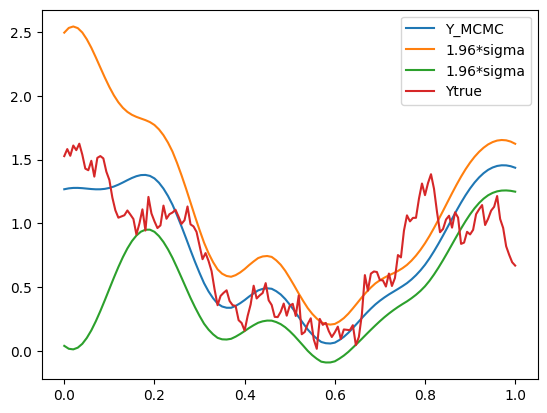

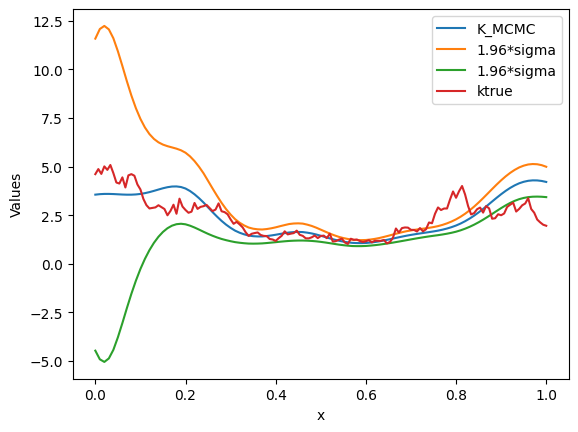

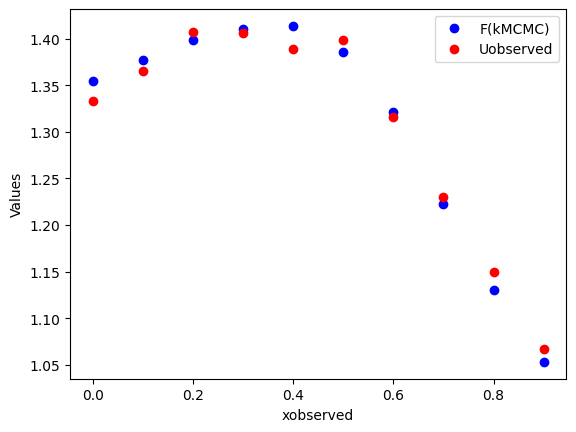

In [ ]:

t_burn_in = 50000
Y_MCMC = np.zeros((len(x), N-t_burn_in))
k_MCMC = np.zeros((len(x), N-t_burn_in))
U_MCMC=np.zeros((N-t_burn_in))
for j in range(t_burn_in , N):
  i = j - t_burn_in
  Y_MCMC[:, i ] = mu_y + (MC_x[:, j ]).dot(psi.T)
  k_MCMC[:, i ] = np.exp(Y_MCMC[:, i ])
  U_MCMC[i]=diffusioneqn(x,F,k_MCMC[:,i],s,u_r)[0]
import numpy as np
import matplotlib.pyplot as plt

# Assuming x, Y_MCMC, ktrue, xgrid, xobserved, u_r, F, s, mean, std, u_values, and Uobserved are defined

# Plotting the first set of curves
plt.figure()
plt.plot(x, np.mean(Y_MCMC, axis=1), label='Y_MCMC')
plt.plot(x, np.mean(Y_MCMC, axis=1) + 1.96*np.std(Y_MCMC, axis=1), label='1.96*sigma')
plt.plot(x, np.mean(Y_MCMC, axis=1) - 1.96*np.std(Y_MCMC, axis=1), label='1.96*sigma')
plt.plot(xgrid, np.log(k_true), label='Ytrue')
plt.legend()

# Plotting the first set of curves
plt.figure()
plt.plot(x, np.exp(np.mean(Y_MCMC, axis=1)), label='K_MCMC')
plt.plot(x, np.exp(np.mean(Y_MCMC, axis=1)) + 1.96*np.std(np.exp(Y_MCMC), axis=1), label='1.96*sigma')
plt.plot(x, np.exp(np.mean(Y_MCMC, axis=1)) - 1.96*np.std(np.exp(Y_MCMC), axis=1), label='1.96*sigma')
# Plotting ktrue
plt.plot(xgrid, k_true, label='ktrue')

# Adding labels and legend
plt.xlabel('x')
plt.ylabel('Values')
plt.legend()
plt.show()

# Plotting the second set of curves
plt.figure()
plt.plot(xobserved, diffusioneqn(x,F,np.mean(k_MCMC, axis=1),s,u_r),'bo', label='F(kMCMC)')
plt.plot(xobserved, Uobserved, 'ro', label='Uobserved')

# Adding labels and legend
plt.xlabel('xobserved')
plt.ylabel('Values')
plt.legend()
plt.show()


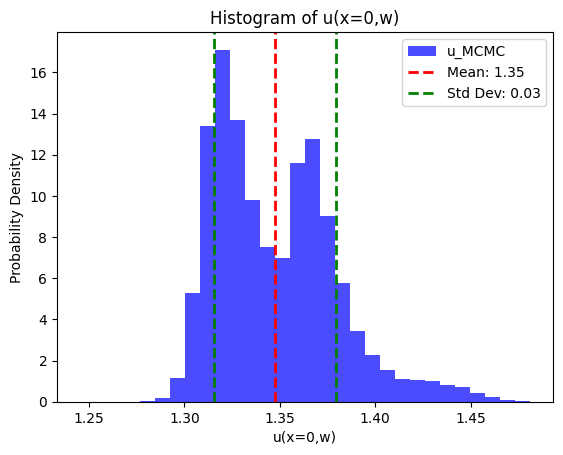

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# Plotting the histogram
plt.hist(U_MCMC, bins=30, density=True, alpha=0.7, color='blue', label='u_MCMC')

# Calculate mean and variance
mean_value = np.mean(U_MCMC)
variance_value = np.var(U_MCMC)

# Plotting mean and variance lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(mean_value + np.sqrt(variance_value), color='green', linestyle='dashed', linewidth=2, label=f'Std Dev: {np.sqrt(variance_value):.2f}')
plt.axvline(mean_value - np.sqrt(variance_value), color='green', linestyle='dashed', linewidth=2)

# Adding labels and title
plt.xlabel('u(x=0,w)')
plt.ylabel('Probability Density')
plt.title('Histogram of u(x=0,w)')
plt.legend()

plt.show()

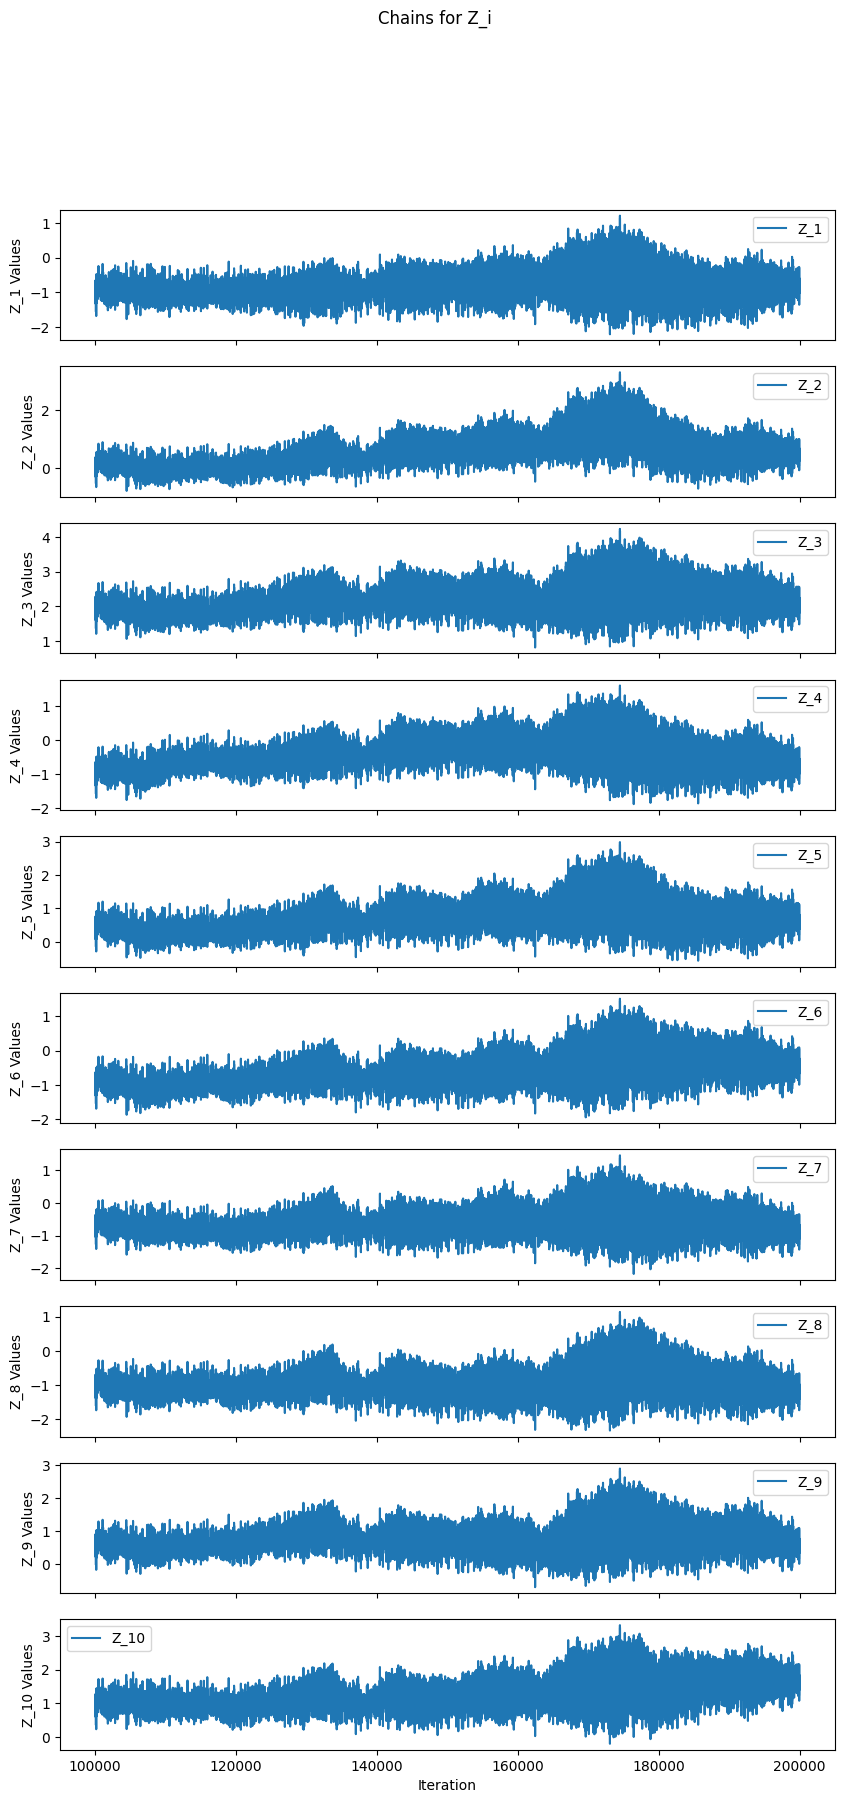

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have MC_x defined with shape (KL_trunc_order, num_iterations)
# Adjust these values accordingly based on your actual data

KL_trunc_order = 10  # Adjust based on your data
num_iterations = N  # Adjust based on your data
t_burn_in = 100000  # Adjust based on your data

# Plotting all Zi in a single plot with subplots
fig, axs = plt.subplots(KL_trunc_order, 1, figsize=(10, 2 * KL_trunc_order), sharex=True)

for i in range(KL_trunc_order):
    axs[i].plot(range(t_burn_in,num_iterations), MC_x[i, t_burn_in:], label=f'Z_{i+1}')
    axs[i].set_ylabel(f'Z_{i+1} Values')
    axs[i].legend()

# Adding labels and title
axs[-1].set_xlabel('Iteration')
fig.suptitle('Chains for Z_i')
plt.show()


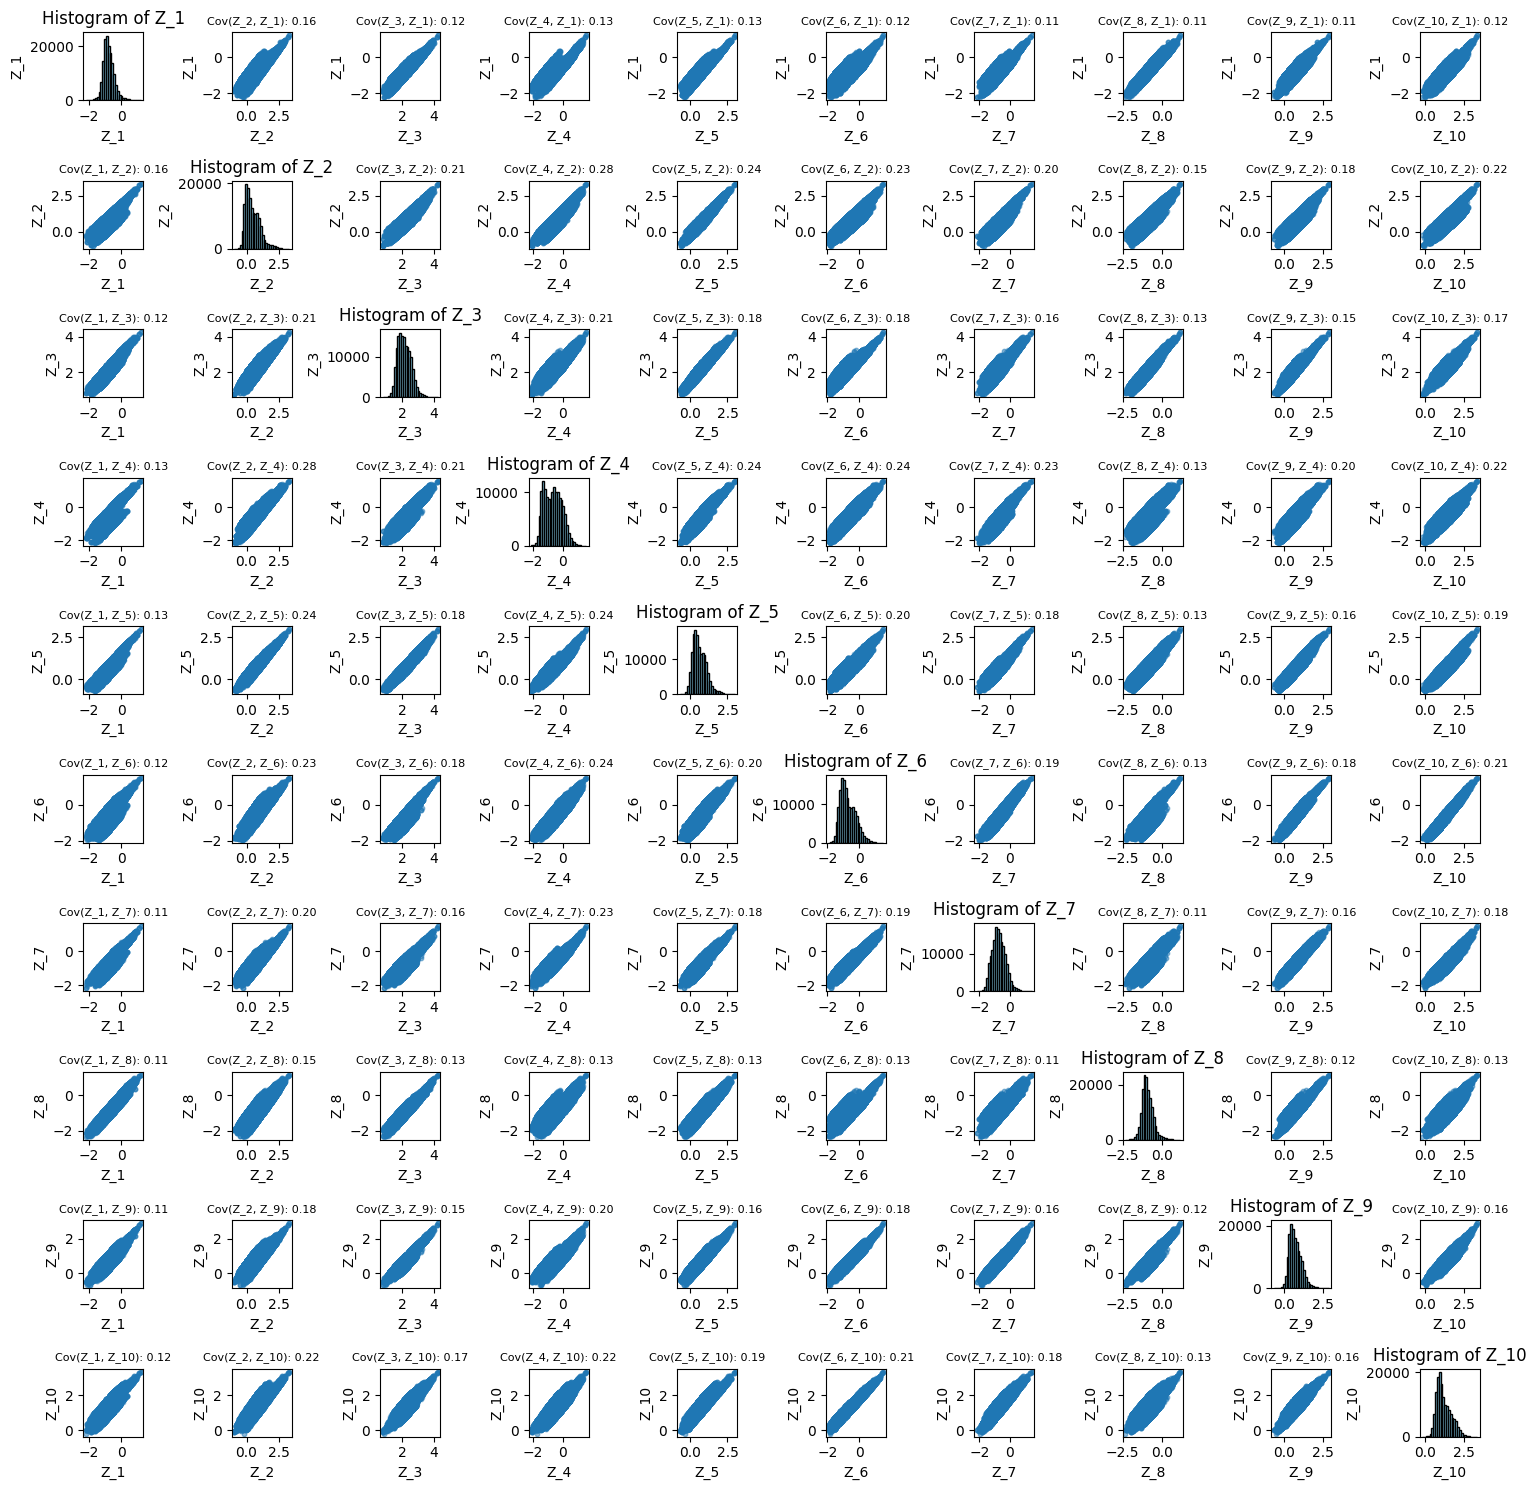

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have MC_x defined with shape (KL_trunc_order, num_iterations)
# Adjust these values accordingly based on your actual data

KL_trunc_order = 10  # Adjust based on your data
num_iterations = N  # Adjust based on your data
t_burn_in = 50000  # Adjust based on your data

# Calculate covariance matrix for MC_x
covariance_matrix = np.cov(MC_x[:, t_burn_in:])

# Create a scatter matrix with histograms
fig, axs = plt.subplots(KL_trunc_order, KL_trunc_order, figsize=(15, 15))
scatter_matrix = axs
for i in range(KL_trunc_order):
    for j in range(KL_trunc_order):
        if i == j:
            # Plot histogram on the diagonal
            axs[i, j].hist(MC_x[i, t_burn_in:], bins=30, color='skyblue', edgecolor='black')
            axs[i, j].set_title(f'Histogram of Z_{i+1}')
        else:
            # Plot scatter plot for off-diagonal elements
            axs[i, j].scatter(MC_x[j, t_burn_in:], MC_x[i, t_burn_in:], alpha=0.5, s=10)
            axs[i, j].set_title(f'Cov(Z_{j+1}, Z_{i+1}): {covariance_matrix[i, j]:.2f}', fontsize=8)

        axs[i, j].set_xlabel(f'Z_{j+1}')
        axs[i, j].set_ylabel(f'Z_{i+1}')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


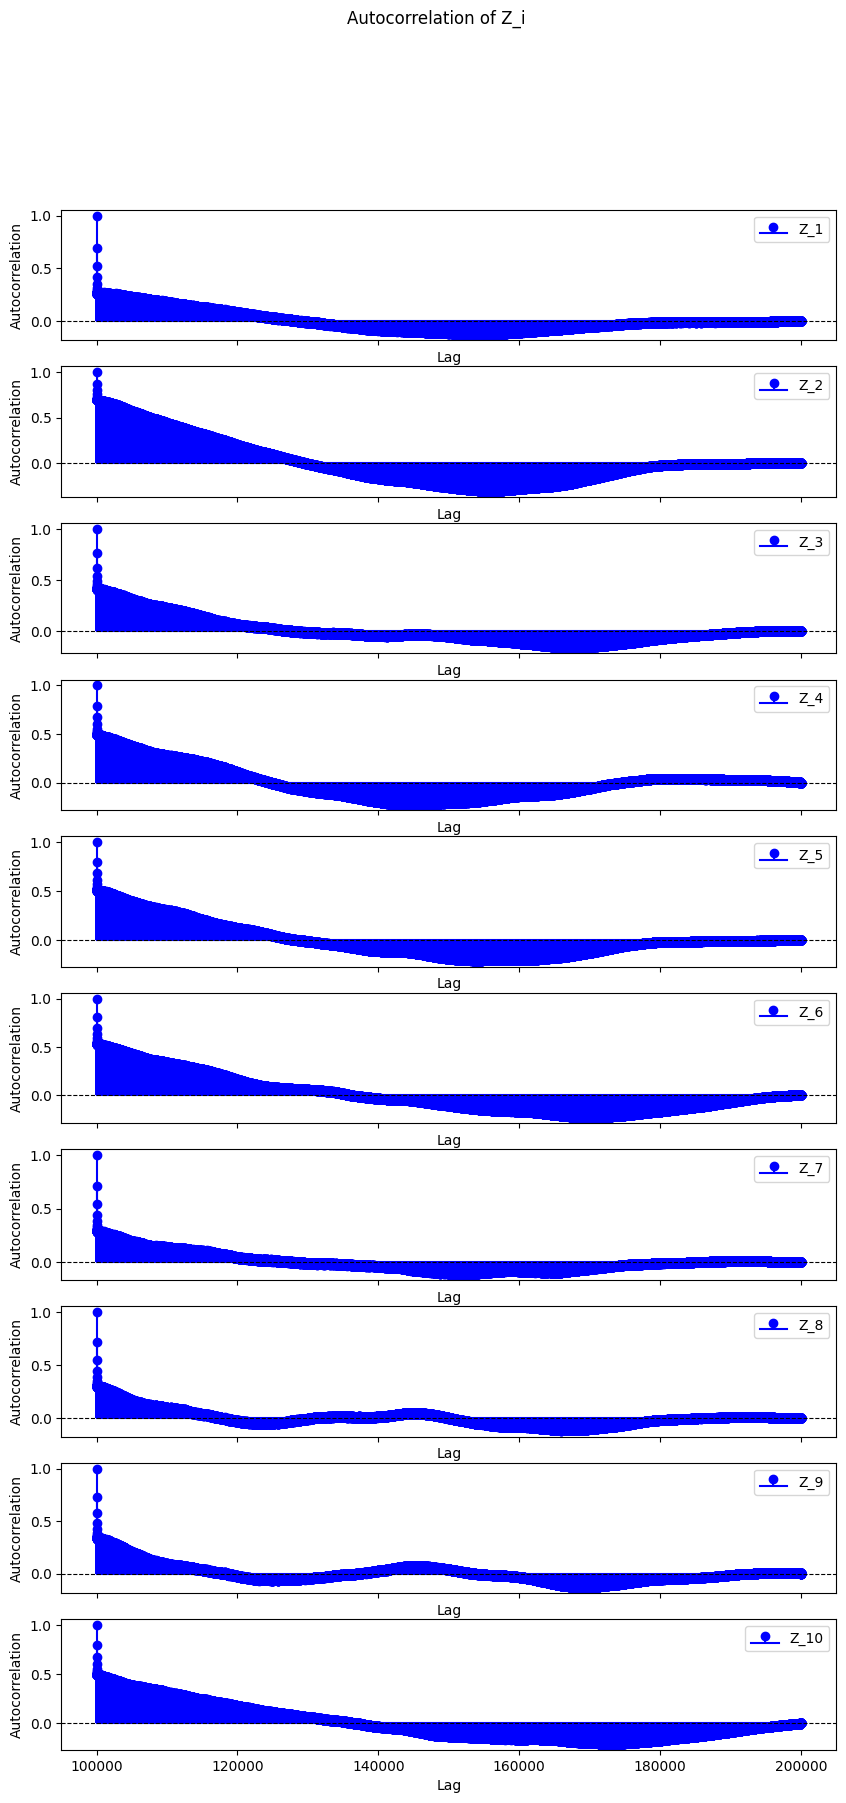

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

KL_trunc_order = 10  # Adjust based on your data
num_iterations = N  # Adjust based on your data
t_burn_in=100000
# Calculate autocorrelation for each Z
autocorrelations = []

for i in range(KL_trunc_order):
    autocorr = np.correlate(
        MC_x[i, t_burn_in:] - np.mean(MC_x[i, t_burn_in:]),
        MC_x[i, t_burn_in:] - np.mean(MC_x[i, t_burn_in:]),
        mode='full'
    )
    autocorr = autocorr / np.max(autocorr)  # Normalize to have values between -1 and 1
    autocorrelations.append(autocorr[num_iterations - t_burn_in - 1:])

# Plot autocorrelation for each Z
fig, axs = plt.subplots(KL_trunc_order, 1, figsize=(10, 2 * KL_trunc_order), sharex=True)

for i in range(KL_trunc_order):
    axs[i].stem(
        range(t_burn_in, num_iterations),
        autocorrelations[i],
        basefmt='b-',
        markerfmt='bo',
        linefmt='b-',  # Connect markers with a line
        label=f'Z_{i+1}'
    )
    axs[i].axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # Add a dashed line at y=0 for clarity
    axs[i].set_xlabel('Lag')
    axs[i].set_ylabel('Autocorrelation')
    axs[i].legend()

# Adding title
fig.suptitle('Autocorrelation of Z_i')
plt.show()
